# Text Cleaning

In [10]:
# Importing all the libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_1samp, wilcoxon
from statsmodels.stats.power import ttest_power
from sklearn.preprocessing import LabelEncoder
import copy

In [2]:
# Loading the Input File
tickets_df = pd.read_excel('input_data.xlsx')
tickets_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [3]:
# Summary
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


# Missing Values



*   Lets replace nan values with '' (empty string)
*   And then concatenate Short Description and Description to form a single column named 'New_Description' and use it as a predictor. so that we won't miss any necessary info about the ticket.



In [4]:
#Filling the Empty Entries
tickets_df['Description'].fillna(' ',inplace=True)
tickets_df['Short description'].fillna(' ',inplace=True)

In [5]:
# Num of words distribution summary
(tickets_df['Assignment group'].value_counts()).describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

•	We can see that there 74 groups in the given dataset 

•	Almost last few groups have only one tickets assignment, there is clear data imbalance.

•	We will Group the last few groups into a single group

### Text Parsing, Cleaning & Discarding non unicode

In [6]:
from dateutil import parser
def is_date(str_):
    try:
        parser.parse(str_)
        return True
    except:
        return False

def Formatting(text):
    text = str(text)
    text=text.lower()
    # Removing date from the text
    text = ' '.join([w for w in text.split() if not is_date(w)])
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Removing addressings
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(charac for charac in text if charac <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for caller in tickets_df['Caller'].unique():
        caller_name = [a for a in caller.split()]
        for name in caller_name: 
            text = text.replace(name,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [7]:
tickets_df['Description'] = tickets_df['Description'].apply(Formatting)
tickets_df['Short description'] = tickets_df['Short description'].apply(Formatting)
tickets_df.shape

(8500, 4)

In [8]:
# Combining all the Rows
tickets_df['Cleaned'] = ''
for i in range(tickets_df.shape[0]):
    if tickets_df['Description'][i] == tickets_df['Short description'][i]:
        tickets_df.loc[i,'Cleaned'] = tickets_df['Description'][i]
    else:
        tickets_df.loc[i,'Cleaned'] = tickets_df['Short description'][i] +' '+ tickets_df['Description'][i]

In [9]:
# Length of the Sentences
Temp = []
for i in range(len(tickets_df['Cleaned'])):
    Temp.append(len(tickets_df['Cleaned'][i].split()))
tickets_df['Length'] = Temp

In [10]:
tickets_df.head()

,Short description,Description,Caller,Assignment group,Cleaned,Length
0,login issue,verified user details employee and manager nam...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee and...,36
1,outlook,hello team my meetings skype meetings etc are ...,hmjdrvpb komuaywn,GRP_0,outlook hello team my meetings skype meetings ...,24
2,cant log in to vpn,hi cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,cant log in to vpn hi cannot log on to vpn best,12
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr tool page,6
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,2


In [11]:
# Discarding the Entries having length less than 2. 
tickets_df = tickets_df[tickets_df['Length'] >= 2]
tickets_df = tickets_df.reset_index()
tickets_df.drop(['index'],inplace = True,axis = 1)

In [12]:
!pip install google_trans_new

In [13]:
!pip install langdetect

### Language Translator

In [14]:
from google_trans_new import google_translator
import time
import langdetect

def translate(text):
    translator = google_translator(url_suffix="ind",timeout=5)
    translatedText = translator.translate(text)
    time.sleep(0.5)
    return translatedText.lower()

### Language Detector

In [15]:
def detect_language_gog(text):
    translator = google_translator()
    temp = translator.detect(text)
    time.sleep(0.5)
    return(temp)

def detect_language(text):
    return(langdetect.detect(text))

 We Used two libraries Lang Detect and Google Translator to translate because,
1) Limited Scope of Lang Detect Library

2) Limited HTTP Requests to Google Translator.

We used Langdetect to detect the languages of the text, Filtered the texts not detected as english.
Passed the Non English indexes through google detection (Because of limit of usage we first used langdetect to remove excess of data load)
Then Translate the Non English text detected by google translator.

In [16]:
# Detecting the language with langdetect
tickets_df['Language'] = tickets_df['Cleaned'].apply(detect_language)

In [17]:
# Languages Detected
tickets_df['Language'].unique()

array(['en', 'no', 'es', 'it', 'af', 'sv', 'sl', 'nl', 'ca', 'tl', 'fr',
       'id', 'fi', 'de', 'da', 'ro', 'pl', 'et', 'cy', 'pt', 'hr', 'sq',
       'cs', 'lv', 'so', 'lt', 'hu'], dtype=object)

In [18]:
# Collecting Non English Indexes
Non_English_Index = tickets_df[tickets_df['Language'] != 'en'].index

In [19]:
# Passing the Non English Index through google translator to detect any undetected text in LangDetect Library
for i in Non_English_Index:
    Lang = detect_language_gog(tickets_df.loc[i,'Cleaned'])[0]
    tickets_df.loc[i,'Language'] = Lang
    if Lang != 'en':
        tickets_df.loc[i,'Cleaned'] = translate(tickets_df.loc[i,'Cleaned'])

In [20]:
tickets_df.head()

,Short description,Description,Caller,Assignment group,Cleaned,Length,Language
0,login issue,verified user details employee and manager nam...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee and...,36,en
1,outlook,hello team my meetings skype meetings etc are ...,hmjdrvpb komuaywn,GRP_0,outlook hello team my meetings skype meetings ...,24,en
2,cant log in to vpn,hi cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,cant log in to vpn hi cannot log on to vpn best,12,en
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr tool page,6,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,2,en


### Removing Stop words

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalpesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
for i,text in enumerate(tickets_df['Cleaned']):
    tickets_df.loc[i,'Cleaned'] =" ".join(word for word in text.split(' ') if word not in stopwords.words('english'))

### Lemmatize Words

In [23]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(text):
    doc = nlp(text)
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    temp = []
    for word in doc:
         if word.pos_ in allowed_postags:
            temp.append(word.lemma_)
    return(' '.join(temp))

In [24]:
# Applying Lametization
for i in tickets_df.index:
    tickets_df.loc[i,'Cleaned'] = lemmatize(tickets_df.loc[i,'Cleaned'])

# Trying spell checkers ( Will try later)

In [25]:
# from spellchecker import SpellChecker

# spell = SpellChecker(distance=1)
# spell.word_frequency.load_words(['azure','skype','hostname','oracle','erpdata','vpn'])
# # find those words that may be misspelled
# misspelled = spell.unknown(tickets_df['Cleaned'][8337].split())

# for word in misspelled:
#     # Get the one `most likely` answer
#     print(word)
#     print(spell.correction(word))

# #     # Get a list of `likely` options
# #     print(spell.candidates(word))

In [26]:
## Remove repeated words

In [27]:
# # Gensim
# from gensim.models import Phrases
# from gensim.utils import simple_preprocess

# Request_List =itTicketDF.Cleaned.values.tolist()


# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Df_words = list(sent_to_words(Request_List))

# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# # Form Bigrams
# Df_words_bigrams = make_bigrams(data_words)

In [28]:
tickets_df

,Short description,Description,Caller,Assignment group,Cleaned,Length,Language
0,login issue,verified user details employee and manager nam...,spxjnwir pjlcoqds,GRP_0,login issue verify user detail employee manage...,36,en
1,outlook,hello team my meetings skype meetings etc are ...,hmjdrvpb komuaywn,GRP_0,outlook hello team meeting skype meeting appea...,24,en
2,cant log in to vpn,hi cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,log vpn log vpn good,12,en
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,unable access hr tool page,6,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,2,en
...,...,...,...,...,...,...,...
8427,emails not coming in from zz mail,good afternoon am not receiving the emails tha...,avglmrts vhqmtiua,GRP_29,email come mail good afternoon receiving email...,21,en
8428,telephony software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0,telephony software issue,3,en
8429,vip windows password reset for tifpdchb pedxruyf,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,GRP_0,vip window password reset pedxruyf,7,en
8430,machine o est funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62,machine unable access machine utility finish d...,21,en


In [20]:
Empty_Rows = tickets_df[tickets_df.isnull().any(axis=1)].index
tickets_df.drop(Empty_Rows,axis = 0,inplace = True)

In [30]:
tickets_df.to_excel('Cleaned_data.xlsx')

# EDA

In [11]:
#Importing the data file
tickets_df = pd.read_excel('Cleaned_data.xlsx')

In [37]:
tickets_df[tickets_df['Cleaned'].isnull() == True]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Short description,Description,Caller,Assignment group,Cleaned,Length,Language,Assignment RE-group
2916,2916,2916,2916,s to for,s to for,ughzilfm cfibdamq,GRP_34,NaN,3,en,Others
2992,2992,2992,2992,NaN,kg kg,qypsxviu xagqtblv,GRP_48,NaN,2,pt,Others


In [38]:
tickets_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Short description,Description,Caller,Assignment group,Cleaned,Length,Language,Assignment RE-group
0,0,0,0,login issue,verified user details employee and manager nam...,spxjnwir pjlcoqds,GRP_0,login issue verify user detail employee manage...,36,en,GRP_0
1,1,1,1,outlook,hello team my meetings skype meetings etc are ...,hmjdrvpb komuaywn,GRP_0,outlook hello team meeting skype meeting appea...,24,en,GRP_0
2,2,2,2,cant log in to vpn,hi cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,log vpn log vpn good,12,en,GRP_0
3,3,3,3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,unable access hr tool page,6,en,GRP_0
4,4,4,4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,2,en,GRP_0


Observation:
There are 4 columns and all are string columns

*   There are totally 8500 rows and there seems to be mising values in Short description and Description columns, which needs to be looked into and handled
*   Caller columns mainly contains the details of the user who raised the incident and is of not much use in our analysis and can be dropped.

*   Assignment group is our predictor / target column with multiple classes.

*   This is a Multiclass Classification problem



In [39]:
# Record Distribution of groups
pd.DataFrame(tickets_df['Assignment group'].value_counts())

,Assignment group
GRP_0,3973
GRP_8,661
GRP_24,289
GRP_12,257
GRP_9,252
...,...
GRP_70,1
GRP_67,1
GRP_64,1
GRP_35,1


## The Assigment group contains 74 different classes


## Lets visualize the percentage of incidents per assignment group

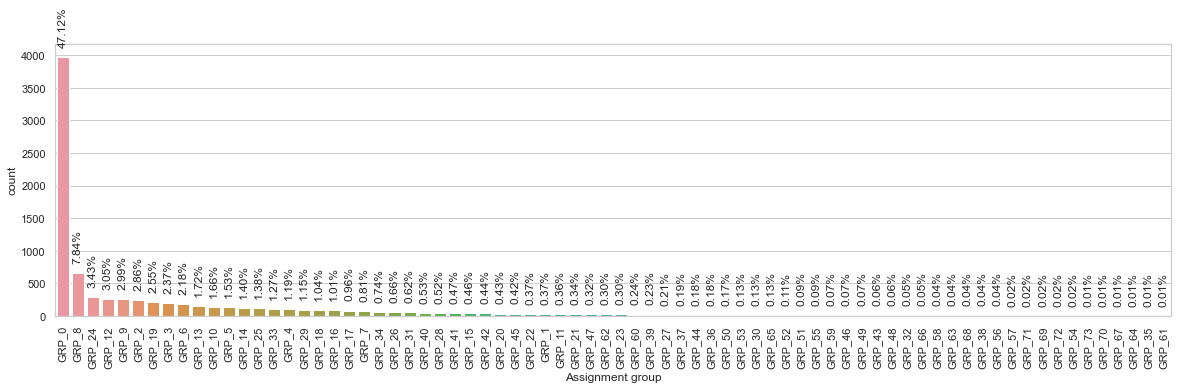

In [40]:
# Plot to visualize the percentage data distribution across different groups
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=tickets_df, order=tickets_df["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(str(format(p.get_height()/len(tickets_df.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

# Observation

---



*   This is a imbalanced dataset, with majority of incidents are from Group 0 followed by Group 8 , 24 , 12 , 9 , 2 and so on
*   There are few classes which just have less 10 incidents pers class and even classed with just 1 or 2 incidents, need to see if we can drop those rows due to the lack of samples representing those classes. They might not be of much help as a predictor



## Lets view the top 20 Assignment groups with highest number of tickets

In [41]:
df_top_20 = tickets_df['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_20

,index,Assignment group
0,GRP_0,3973
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


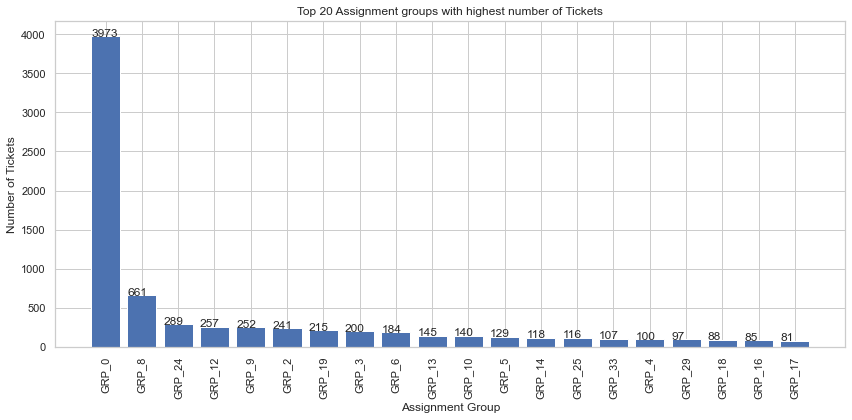

In [42]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_20['index'],df_top_20['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

## Lets view the bottom 20 Assignment groups with less number of tickets

In [43]:
df_bottom_20 = tickets_df['Assignment group'].value_counts().nsmallest(20).reset_index()
df_bottom_20

,index,Assignment group
0,GRP_73,1
1,GRP_70,1
2,GRP_67,1
3,GRP_64,1
4,GRP_35,1
5,GRP_61,1
6,GRP_57,2
7,GRP_71,2
8,GRP_69,2
9,GRP_72,2


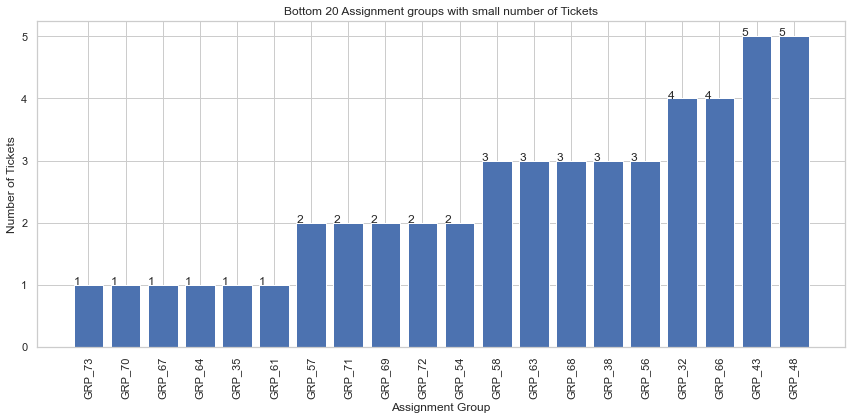

In [44]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_bottom_20['index'],df_bottom_20['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

# Distribution of tickets counts in various bins

In [45]:
df_bins = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1 ticket','Ticket Count':len(tickets_df[tickets_df['Length'] < 2])}
_2_5_ticket = {'Description':'2-5 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 1)& (tickets_df['Length'] < 6) ])}
_10_ticket = {'Description':' 6-10 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 5)& (tickets_df['Length'] < 11)])}
_10_20_ticket = {'Description':' 11-20 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 10)& (tickets_df['Length'] < 21)])}
_20_50_ticket = {'Description':' 21-50 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 20)& (tickets_df['Length'] < 51)])}
_51_100_ticket = {'Description':' 51-100 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 50)& (tickets_df['Length'] < 101)])}
_100_ticket = {'Description':' >100 ticket',
              'Ticket Count':len(tickets_df[(tickets_df['Length'] > 100)])}
#append row to the dataframe
df_bins = df_bins.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_bins

,Description,Ticket Count
0,1 ticket,0
1,2-5 ticket,1704
2,6-10 ticket,1928
3,11-20 ticket,1469
4,21-50 ticket,2241
5,51-100 ticket,689
6,>100 ticket,401


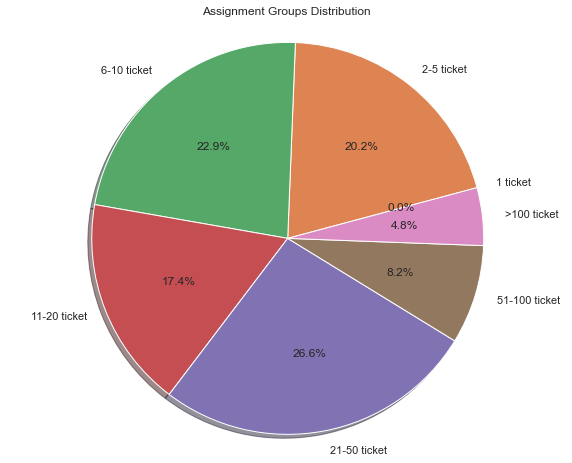

In [46]:
plt.figure(figsize=(10, 8))
plt.pie(df_bins['Ticket Count'],labels=df_bins['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal');


*   We see that there are 6 Assignment Group’s for which just have 1 ticket in the dataset
*   There are 15 Assignment group’s which have more than 100 tickets.
*   Only 20% of the Assignment groups have greater than 100 tickets.



In [47]:
# # Selecting the Groups having more than 100 Indiviual records
# Counts = pd.DataFrame(tickets_df['Assignment group'].value_counts())
# Others = []
# for Group in tickets_df['Assignment group'].unique():
#     if Counts.loc[Group][0] < 100:
#         Others.append(Group)
# print('{0} Groups in dataset have less than 100 samples'.format(len(Others)))

# tickets_df['Assignment RE-group'] =tickets_df['Assignment group'].apply(lambda x: 'Others' if x in Others else x)

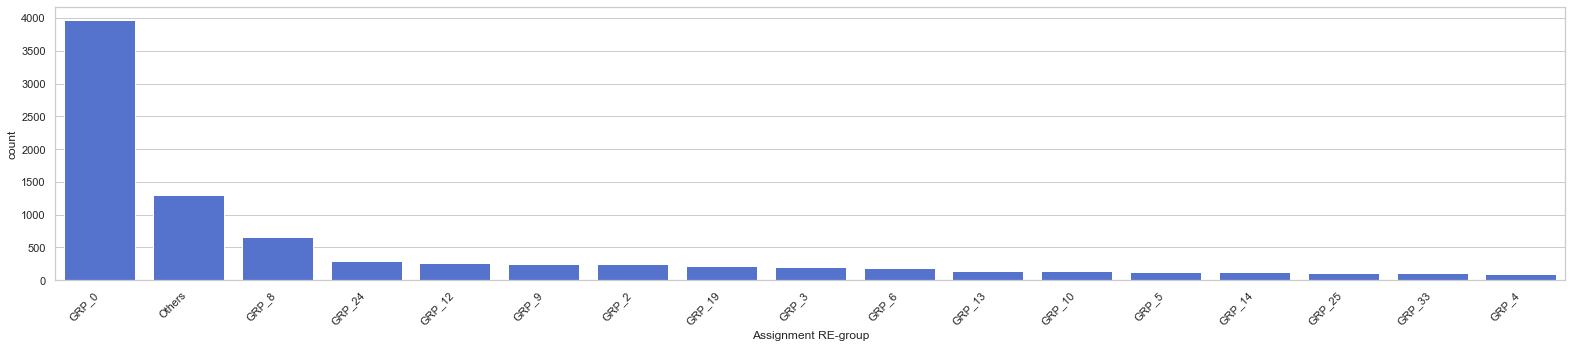

In [48]:
# Visualising the Distribution after re-classifing the groups in 'Others'.
plt.subplots(figsize=(22,5))
descending_order = tickets_df['Assignment RE-group'].value_counts().sort_values(ascending=False).index
ax=sns.countplot(x='Assignment RE-group', data=tickets_df, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Let use word cloud to visualize the type of words used in Description

One very handy visualization tool for a data scientist when it comes to any sort of natural language processing is plotting "Word Cloud". A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here our words can simply be taken from the column "text"

In [49]:
def f_word_cloud(column):
    
    comment_words = ' '
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in column: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    
    return wordcloud

In [50]:
! pip install wordcloud

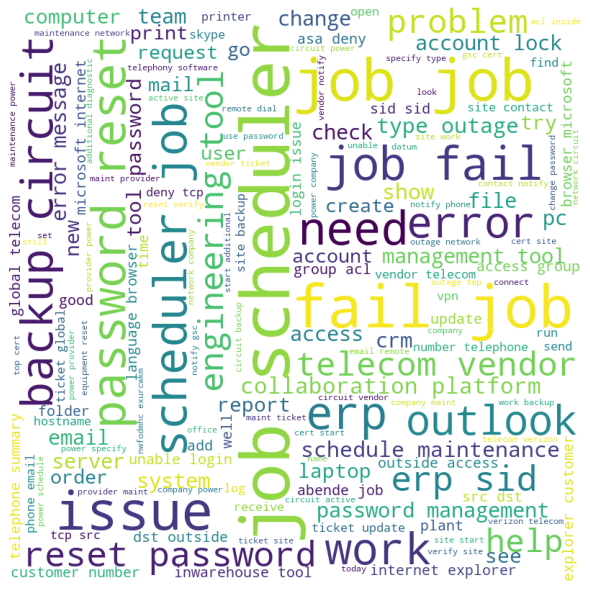

In [51]:
from wordcloud import WordCloud, STOPWORDS 


wordcloud = f_word_cloud(tickets_df.Cleaned)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Lets view the word cloud of top 4 assignment groups to see the kind of tickets assigned to them

## Word Cloud for tickets with Assignment group 'GRP_0'

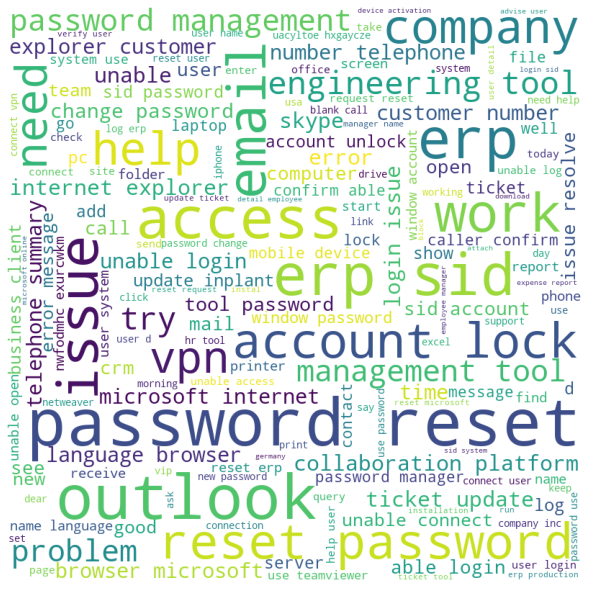

In [52]:
wordcloud = f_word_cloud(tickets_df[tickets_df['Assignment group']=='GRP_0'].Cleaned)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_0 seems to have tickets related to password reset, access issues , login issue, connectivity issue etc..

## Word Cloud for tickets with Assignment group 'GRP_8'

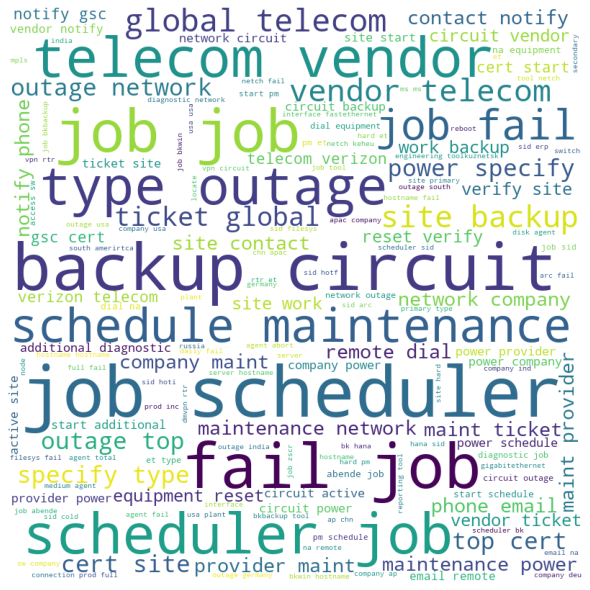

In [53]:
wordcloud = f_word_cloud(tickets_df[tickets_df['Assignment group']=='GRP_8'].Cleaned)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_8 seems to have tickets related to outage, job failures, monitoring tool etc

## Word Cloud for tickets with Assignment group 'GRP_12'

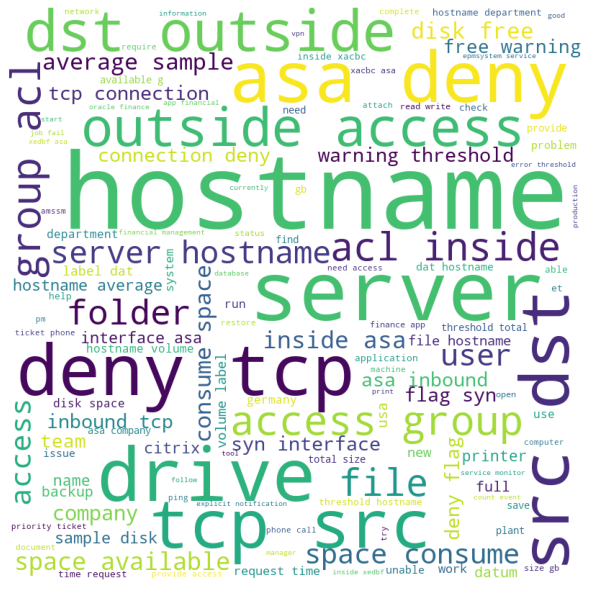

In [54]:
wordcloud = f_word_cloud(tickets_df[tickets_df['Assignment group']=='GRP_12'].Cleaned)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_12 contains tickets related to systems like disk space issues, t network issues like tie out, citrix issue, connectivity timeout etc.

## Word Cloud for tickets with Assignment group 'GRP_24'

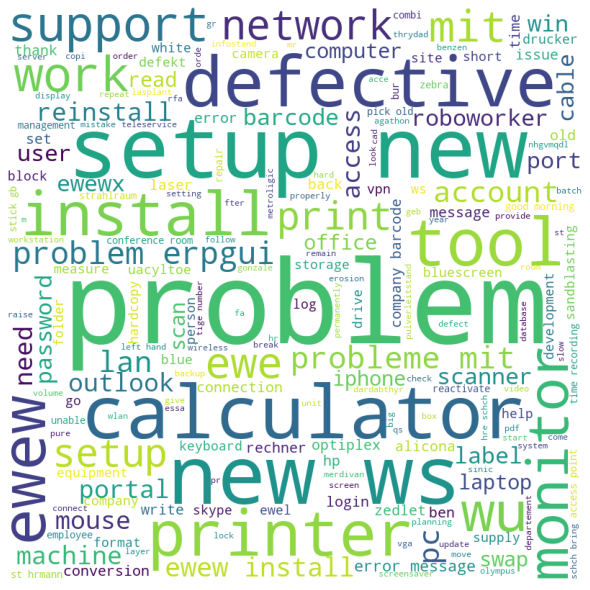

In [55]:
wordcloud = f_word_cloud(tickets_df[tickets_df['Assignment group']=='GRP_24'].Cleaned)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

GRP_24 - Tickets are mainly in german, these tickets need to be translated to english before passing it to our model.

## Detect the language the ticket is raised by

C:\Users\Kalpesh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


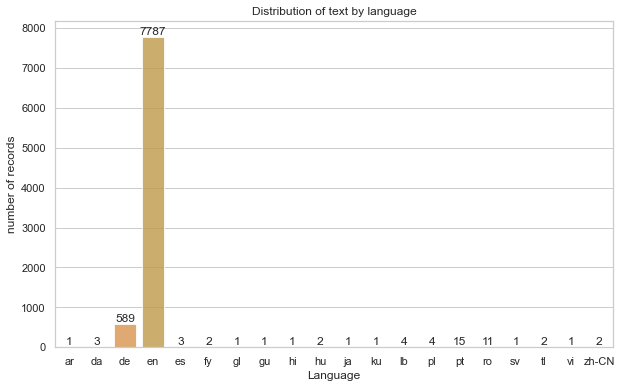

In [56]:
x = tickets_df["Language"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();  

In [57]:
tickets_df.to_excel('Cleaned_data.xlsx')

# Model Building

Checking the first 5 rows of the cleaned data

In [12]:
# tickets_df = tickets_df[tickets_df['Assignment RE-group'] != 'GRP_0']

Empty_Rows = tickets_df[tickets_df.isnull().any(axis=1)].index
tickets_df.drop(Empty_Rows,axis = 0,inplace = True)


*   We will try to remove the "others" category from the "Assignment RE-group" column because we are only considering categories having more than 100 tickets.




In [13]:
tickets_df['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57',
       'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32', 'GRP_62',
       'GRP_63', 'GRP_64', 'GRP_48', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

Making sure whether the above change has been made or not. We can see we have removed the "other" category.

In [14]:
# tickets_df = tickets_df[tickets_df['Cleaned'].duplicated(keep='first')]

In [15]:
tickets_df.shape

(8398, 12)

In [16]:
max_features = 10000
maxlen = 50
embedding_size = 300

Specifying the max_features, maximum length and embedding size 

In [17]:
from sklearn import preprocessing

In [18]:
label_encoder = preprocessing.LabelEncoder()
tickets_df['Assignment group']= label_encoder.fit_transform(tickets_df['Assignment group'])

In [31]:
l1 = list(label_encoder.classes_)

f=open('labels.txt','w')
for ele in l1:
    f.write(ele+'\n')
f.close()

In [6]:
f=open('labels.txt','r')
lines = f.readlines()
Labels = []
for line in lines:
    Labels.append(line.replace('\n',''))

Here we are simply lable encoding the target categories 



In [26]:
X = tickets_df["Cleaned"]
y = tickets_df["Assignment group"]

Splitting the independent and dependent variables into X and Y

In [27]:
from sklearn.model_selection import train_test_split

Importing train_test_split from sklearn

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer(num_words=max_features)
tk.fit_on_texts(X.values)
tk.texts_to_sequences(X)
X = tk.texts_to_sequences(X.values)

import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

Tokenizing the sentences so that we get a single integer assigned to each and very in our corpus. 
We will also use text to sequence after tokenizing so that we retain the order of the sentence

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X,maxlen=maxlen,padding='post')
y = np.array(y)

We have already defined the max length as 100 above so sentences having characters more than 100 will be reduced to 100 and sentences having less than 100 characters will be added with 0 padding.

In [30]:
from tensorflow.keras.utils import to_categorical
y= to_categorical(y,num_classes = 74)



*   Converting our labels into 1*16 one hot vector.




In [31]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

Splitting the data into x_test, y_test, x_train and y_train

In [33]:
tk.word_index

{'job': 1,
 'password': 2,
 'erp': 3,
 'user': 4,
 'tool': 5,
 'company': 6,
 'access': 7,
 'issue': 8,
 'reset': 9,
 'sid': 10,
 'scheduler': 11,
 'ticket': 12,
 'work': 13,
 'error': 14,
 'unable': 15,
 'fail': 16,
 'account': 17,
 'need': 18,
 'email': 19,
 'site': 20,
 'hostname': 21,
 'help': 22,
 'system': 23,
 'name': 24,
 'get': 25,
 'login': 26,
 'outlook': 27,
 'circuit': 28,
 'network': 29,
 'use': 30,
 'power': 31,
 'message': 32,
 'vendor': 33,
 'change': 34,
 'event': 35,
 'problem': 36,
 'update': 37,
 'see': 38,
 'server': 39,
 'backup': 40,
 'printer': 41,
 'log': 42,
 'time': 43,
 'new': 44,
 'phone': 45,
 'telecom': 46,
 'd': 47,
 'check': 48,
 'try': 49,
 'outage': 50,
 'request': 51,
 'able': 52,
 'order': 53,
 'start': 54,
 'team': 55,
 'call': 56,
 'number': 57,
 'connect': 58,
 'type': 59,
 'vpn': 60,
 'customer': 61,
 'crm': 62,
 'window': 63,
 'lock': 64,
 'contact': 65,
 'open': 66,
 'device': 67,
 'usa': 68,
 'plant': 69,
 'engineering': 70,
 'report': 71,
 

Checking the indexes assigned to each word

In [34]:
num_words = len(tk.word_index) + 1
print(num_words)

9954


We have an integer for each word but we don't have any index assigend to 0 which gets introduced by doing padding. So along with the total no. of words in our corpus we also have a 0. Therefore we will increase the word count by 1

In [35]:
from tqdm.notebook import tqdm

Importing TQDM  library checking the progress of for loop

In [36]:
with open("wiki-news-300d-1M.vec", 'rb') as vecfile:  
    embeddings = {}
    limit = 4
    l = vecfile.readlines()
    l.pop(0)
    for index,line in tqdm(enumerate(l)):
        conv = str(line, 'utf-8')
        word = conv.split(" ")[0]
        embd = conv.split(" ")[1:]
        embd = list(map(float,embd))
        embd = np.asarray(embd)
        embeddings[word] = embd 

Loading the fastext 300 dimensional word embeddings and making key value pairs of each word and it's embeddings

Counting the total no. of words in the embedding

In [38]:
embedding_matrix = np.zeros((num_words, 300))
for word, i in tk.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


Making an embedding matrix of the word in our corpus from the fastext embedding dictionary we just made above

In [39]:
embedding_matrix[4] 

array([ 0.0793,  0.0079,  0.0555, -0.0205,  0.0599, -0.0173, -0.0016,
        0.0223,  0.0595, -0.0254, -0.0138, -0.1036,  0.0826,  0.1204,
        0.0047, -0.0539, -0.0558,  0.2797, -0.0729,  0.0893, -0.1861,
       -0.2061,  0.159 ,  0.0328, -0.0833, -0.0096, -0.0399, -0.0598,
       -0.1119, -0.0052, -0.0543,  0.0368,  0.0578, -0.0288,  0.0152,
        0.16  ,  0.1459,  0.0465, -0.1142, -0.0805,  0.1349,  0.0502,
        0.0654, -0.0773, -0.1373, -0.2127, -0.0183, -0.048 ,  0.0552,
        0.0953, -0.0552,  0.0823, -0.6591,  0.1621,  0.2107,  0.0116,
       -0.022 , -0.0585, -0.0517,  0.0312,  0.1493,  0.021 , -0.1256,
        0.0572,  0.0276, -0.0512, -0.0944, -0.0964, -0.0221, -0.0047,
       -0.0039,  0.1116, -0.0239,  0.1679,  0.0164, -0.1096, -0.0972,
        0.0773,  0.0245,  0.1387,  0.0412,  0.0705,  0.036 , -0.175 ,
        0.0887, -0.1058, -0.0594, -0.0203,  0.1671,  0.0715,  0.0067,
       -0.0474, -0.0628, -0.0889,  0.1373, -0.0166, -0.0474, -0.1874,
        0.0823, -0.0

Randomly checking the 5th row of our embedding matrix just to make sure everything is good

In [79]:
vocab_len = embedding_matrix.shape[0]

9954

vocab_len will be the no. of words in our embedding matrix therefore taking it from the 0th index of the shape of embedding matrix

In [41]:
from tensorflow.keras.layers import LSTM,Embedding,Flatten,Input,Dense,Bidirectional
from tensorflow.keras.models import Sequential

Importing LSTM, Embedding, Flatten, Input, Dense, Bidirectional and Sequential

In [71]:
model = Sequential()
model.add(Embedding(input_dim = vocab_len,output_dim = embedding_size,weights = [embedding_matrix],input_length=maxlen,trainable = False))
model.add(Bidirectional(LSTM(100,return_sequences=False)))

model.add(Dense(64))
model.add(Dense(74,activation='softmax'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           2986200   
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_13 (Dense)             (None, 74)                4810      
Total params: 3,064,474
Trainable params: 78,274
Non-trainable params: 2,986,200
_________________________________________________________________
None


In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Bidirectional,Input

Input = Input(shape = (50,))
embeding = Embedding(input_dim = vocab_len,output_dim = embedding_size,weights = [embedding_matrix],input_length=maxlen,trainable = False)(Input)
dropout = Dropout(0.2)(embeding)
lstm = Bidirectional(LSTM(100, recurrent_dropout=0.2))(dropout)
hidden_dense = Dense(64,activation ='relu')(lstm)
output = Dense(74,activation='softmax')(hidden_dense)

Defining the model. 
1. Creating an embedding layer with input dimensions as vocab_len, output_dim as embedding_size which is 300 as fastext embedding are 300 dimensional. We will not train this layer as it will directly take weights from the embedding matrix we just made above.
2. Adding a birectional LSTM with 100 units in it
3. Converting the output of LSTM using a flattened layer
4. Feeding the falltened output to a fully connected layer with 64 neurons.
5. Finally feeding the output of the previous dense layer to a 16 neuron network with activation as "softmax" so that it classifies them into respective categories

In [81]:
from tensorflow.keras.optimizers import Adam

In [82]:
model = Model(inputs = Input,outputs =output)

Importing the Adam optimiser

In [83]:
# Optimizer
adam = Adam(lr = 1e-3,beta_1 = 0.9,decay = 1e-3)

model.compile(optimizer=adam,loss = "categorical_crossentropy",metrics=['accuracy'])

Compiling the model using optimizer as 'Adam', loss as 'categorical Cross entropy' and metrics as 'Accuracy'

In [84]:
model.fit(x_train,y_train,batch_size=64,epochs=20,validation_data=(x_test,y_test))

Epoch 1/20
105/105 [==============================] - 39s 256ms/step - loss: 3.1054 - accuracy: 0.4364 - val_loss: 2.0859 - val_accuracy: 0.5470
Epoch 2/20
105/105 [==============================] - 23s 217ms/step - loss: 1.9962 - accuracy: 0.5429 - val_loss: 1.8179 - val_accuracy: 0.5690
Epoch 3/20
105/105 [==============================] - 22s 210ms/step - loss: 1.7694 - accuracy: 0.5634 - val_loss: 1.6883 - val_accuracy: 0.5911
Epoch 4/20
105/105 [==============================] - 23s 224ms/step - loss: 1.6046 - accuracy: 0.5978 - val_loss: 1.5856 - val_accuracy: 0.6030
Epoch 5/20
105/105 [==============================] - 24s 229ms/step - loss: 1.5282 - accuracy: 0.6076 - val_loss: 1.5226 - val_accuracy: 0.6119
Epoch 6/20
105/105 [==============================] - 23s 216ms/step - loss: 1.4345 - accuracy: 0.6162 - val_loss: 1.4811 - val_accuracy: 0.6226
Epoch 7/20
105/105 [==============================] - 23s 221ms/step - loss: 1.3625 - accuracy: 0.6314 - val_loss: 1.4518 - val_ac

Fiting the data into the model and training it for 20 epochs

In [77]:
model.evaluate(x_test,y_test)

45/45 [==============================] - 1s 27ms/step - loss: 1.0102 - accuracy: 0.7504


[1.0102076530456543, 0.7503506541252136]